In [3]:
from gerrychain import Partition, Graph
from gerrychain.updaters import cut_edges, Tally
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import  LineString, mapping
import edges

<AxesSubplot:>

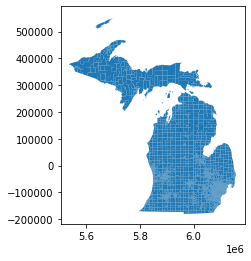

In [4]:
# First Read Shapefile
mi = gpd.read_file('https://github.com/mggg-states/MI-shapefiles/blob/main/MI.zip?raw=true')
mi.plot()

In [5]:
# Now make our graph
badgraph = Graph.from_file('../Michigan/MI_shapefile/MI.shp')

/Users/jdeschler/opt/miniconda3/envs/gerrychain-env/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(3661, 4065), (3909, 4065)}
  overlaps
/Users/jdeschler/opt/miniconda3/envs/gerrychain-env/lib/python3.7/site-packages/gerrychain/graph/graph.py:239: UserWarning: Found islands (degree-0 nodes). Indices of islands: {272, 655, 21, 181}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


In [6]:
# from consulting mggg-states, we know the primary key
key = "VTD"

[4567, 231, 1, 2, 1, 1, 1, 5]


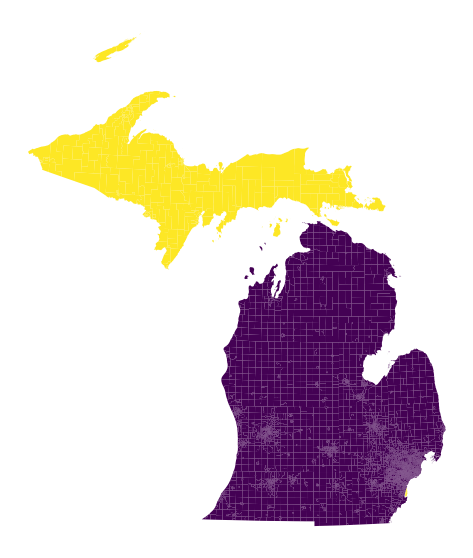

In [7]:
# Oh no, there are islands, but _where_ are the islands?
problems = edges.plot_problems(badgraph, mi, key = key)

[4567, 231, 1, 2, 1, 1, 1, 5]


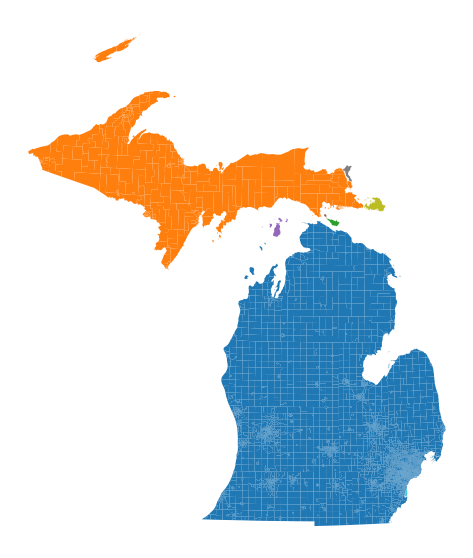

In [8]:
# is the whole UP just one island?!?
edges.plot_components(badgraph, mi, key = key)

In [9]:
# handily, our python anywhere server has a different graph!
graph = Graph.from_json('../Michigan/Final/michigan_old.json')

[4809]


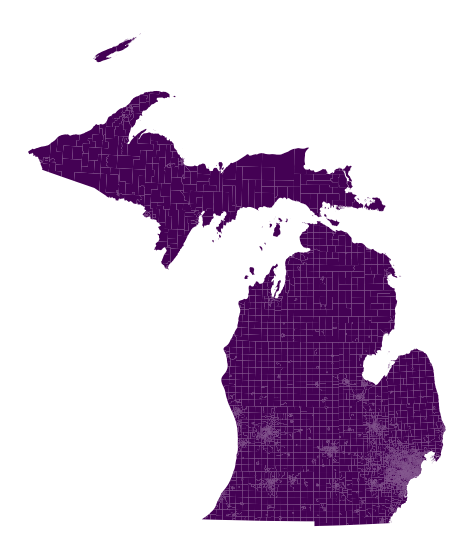

[]

In [10]:
# no island warnings! let's check
edges.plot_problems(graph, mi, key = key)

In [11]:
# This all looks great
# but, hey, we better double check
edges.edges_to_shapefile(graph, mi, key = key, outfile = "shp/old_graph_edges.shp")
# (switch to QGIS)

In [12]:
# wow there's one really long edge, better write down the VTDs of the end points
long_edge = ("P0331128000001", "P1633542000002")

In [13]:
# better remove that edge
graph = edges.remove_edge_by_feature(graph, long_edge[0], long_edge[1], key = key)

NetworkXError: The edge 2755-3452 is not in the graph

In [ ]:
# Excuse me?!?!?
# Weird things must be happening in Michigan...
# Back to QGIS!

In [14]:
# luckily, there's a function for this for folks who weren't assigned to 
# northern michigan on a recent political campaign
edges.edges_to_shapefile_endpoints(graph, mi, key = key, endpoints = "precinct", outfile = 'shp/old_graph_with_endpoints.shp')

# back to QGIS!

In [15]:
# now let's remove the edge
# note that 'precinct' will also be a primary key!
long_edge = ("SOO TOWNSHIP; 1", "GROSSE ILE TOWNSHIP; 2")
graph = edges.remove_edge_by_feature(graph, long_edge[0], long_edge[1], key = 'precinct')

In [16]:
long_removed = edges.edges_to_gdf_endpoints(graph, mi, key = key, endpoints = "precinct")
long_removed.to_file('shp/long_edge_removed.shp')

<AxesSubplot:>

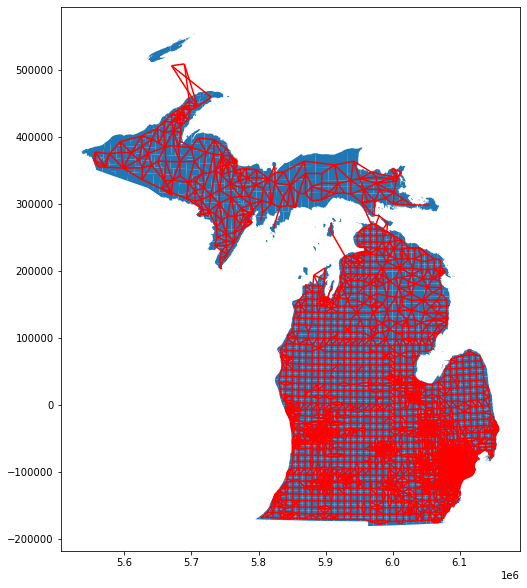

In [17]:
# maybe we don't have to go to QGIS _every_ time
fig, ax = plt.subplots(figsize = (20,10))
mi.plot(ax = ax)
long_removed.plot(ax = ax, color = 'red')

In [ ]:
# Huzzah!
# But there's actually one other problem with this graph...
# Back to QGIS!

In [18]:
to_add = [("GROSSE ILE TOWNSHIP; 2", "TRENTON CITY; 1"), ("GROSSE ILE TOWNSHIP; 2", "RIVERVIEW CITY; 1")]

In [19]:
for u, v in to_add:
    graph = edges.add_edge_by_feature(graph, u, v, key = 'precinct')
graph = edges.remove_edge_by_feature(graph, "GROSSE ILE TOWNSHIP; 5", "BROWNSTOWN TOWNSHIP; 8", key = 'precinct')

In [20]:
edges.edges_to_shapefile_endpoints(graph, mi, key = key, endpoints = "precinct", outfile = 'shp/final_mi.shp')

In [21]:
# but what if we want to visualize the edges we added?
es = edges.edges_to_gdf_endpoints(graph, mi, key = key, endpoints = "precinct")
es.head()

,endpoint_u,endpoint_v,geometry
0,SOUTH HAVEN CITY; 1,SOUTH HAVEN CITY; Ward 3; Precinct 1,"LINESTRING (5844051.229 -97686.226, 5843072.25..."
1,SOUTH HAVEN CITY; 1,CASCO TOWNSHIP; 1,"LINESTRING (5844051.229 -97686.226, 5849678.53..."
2,DETROIT CITY; 11,DETROIT CITY; 15,"LINESTRING (6117189.027 -99556.357, 6116452.90..."
3,DETROIT CITY; 11,DETROIT CITY; 17,"LINESTRING (6117189.027 -99556.357, 6117395.29..."
4,DETROIT CITY; 11,DETROIT CITY; 51,"LINESTRING (6117189.027 -99556.357, 6116532.94..."


In [22]:
# let's mark them!
es = edges.mark_edges(es, to_add, col = "AddedJD", val = 1)
es.head()

,endpoint_u,endpoint_v,geometry,AddedJD
0,SOUTH HAVEN CITY; 1,SOUTH HAVEN CITY; Ward 3; Precinct 1,"LINESTRING (5844051.229 -97686.226, 5843072.25...",0
1,SOUTH HAVEN CITY; 1,CASCO TOWNSHIP; 1,"LINESTRING (5844051.229 -97686.226, 5849678.53...",0
2,DETROIT CITY; 11,DETROIT CITY; 15,"LINESTRING (6117189.027 -99556.357, 6116452.90...",0
3,DETROIT CITY; 11,DETROIT CITY; 17,"LINESTRING (6117189.027 -99556.357, 6117395.29...",0
4,DETROIT CITY; 11,DETROIT CITY; 51,"LINESTRING (6117189.027 -99556.357, 6116532.94...",0


In [23]:
es.to_file('shp/final_marked.shp')

<AxesSubplot:>

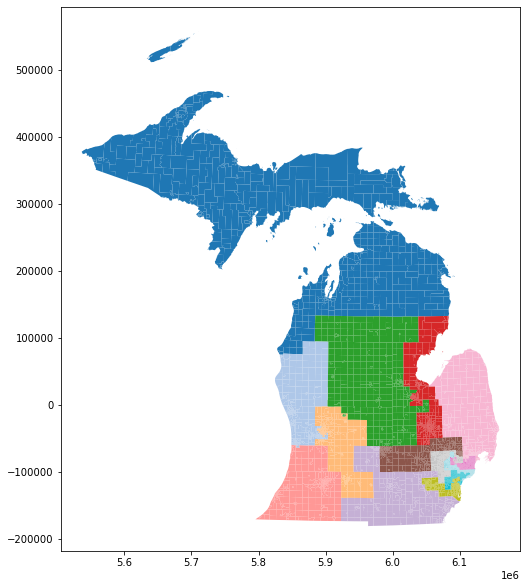

In [24]:
# Hmm, what if I want to see which edges a district plan would cut?
mi.plot(figsize = (20,10), column = "CD", cmap = "tab20")

In [25]:
# better create a partition
partition = Partition(
    graph,
    "CD",
    updaters = {"cut_edges": cut_edges}
)

In [26]:
cuts = partition.cut_edges
# this is the one tricky thing you have to do, bc of how the endpoints are stored
cuts_list = list(map(lambda x: (graph.nodes[x[0]]['precinct'], graph.nodes[x[1]]['precinct']), cuts))

In [ ]:
# this takes a while, so we will go to QGIS!
broken = edges.mark_edges(es, cuts_list, col = "cutbyCD")

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
mi.plot(ax = ax)
broken.plot(ax = ax, column = "cutbyCD")

In [ ]:
broken.to_file('shp/cutbyCD.shp')